<a href="https://colab.research.google.com/github/jwangjie/jwangjie.github.io/blob/master/Illistrative_Example_gpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illistrative Comparison of NMPC, FBL-MPC, GP-NMPC, GP-FBL-MPC. 

Two out of five controllers are reproductions of section `3.4 illistrative example` of the Paper [Learning‐based Nonlinear Model Predictive Control to Improve Vision‐based Mobile Robot Path Tracking](https://onlinelibrary.wiley.com/doi/full/10.1002/rob.21587?casa_token=hdiHqQ9ifc0AAAAA%3A9Srgayhlu9ARM1qtSHHR9ZbdMY19OqDX79WJxFUBAwhpczO85iV9kqmpxChGY7ySnUorhcoCDVxx). 

Here, `NMPC` is the `MPC`, and `Feedback control` is the `Feedback control` of the paper. 

Controllers list:

- [x] NMPC   
- [x] FBL-MPC
- [x] Proportional Feedback Control 
- [ ] GP-NMPC
- [ ] GP-FBL-MPC

In [1]:
# for colab 
!pip install GPy

     |████████████████████████████████| 1.0MB 2.8MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633925 sha256=decb9565bc1d1c28f4aaa74146afe3f08bacb9ff4b5f596a4374bb79570fe0e8
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=023c56536ac87d196187cf0efec874374a32c670eade70a7d86b71e7df562820
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
from numpy.linalg import inv
import GPy

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.format'] = 'pdf'

### Simulation Parameters

In [4]:
simtime = 6
T = 0.01
p = 10  # prediction steps
N = int(simtime / T)  # simulation steps
t = np.linspace(0, simtime, N)

alpha = 0.99  # eqn. 26
beta = 0.5

maxiterations = 100  # for optimization loop
thresh = 0.0001     # for optimization loop, eqn. 14
d = np.zeros((1, N + p))  # disturbance

Create disturbance signals shown in Figure 4

In [5]:
for k in range(1, 2*int(N/6)):
    d[0, k] = 0
for k in range(2*int(N/6), int(3*N/6)):
    d[0, k] = 4
for k in range(int(3*N/6), int(4.5*N/6)):
    d[0, k] = 0
for k in range(int(4.5*N/6), int(5.5*N/6)):
    d[0, k] = 4
for k in range(int(5.5*N/6), int(6*N/6)):
    d[0, k] = 0

In [6]:
#plt.plot(t, d[0, 0:N])

### Generate Reference Trajectories

In [7]:
zd = np.zeros((1, N+p))

In [8]:
for k in range(1, int(N/6)):
    zd[0, k] = 0
for k in range(int(N/6), int(5*N/6)):
    zd[0, k] = 2
for k in range(int(5*N/6), int(N/6+p)):
    zd[0, k] = 0

In [9]:
#plt.plot(t, zd[0, 0:N])

### Simulations 

In this Illistrative example, n = 1. System state and control are one dimensional. 

Define the "True" process model for **simulation** purposes. It's used to simulate the real vehicle plant. 

In [10]:
def process(u, q, T, d):
    new_q = alpha*q + T*beta*u + T*d
    return new_q

Nominal process model used in MPC. This is the model used in the MPC controller. For learning based MPC, the complete systme model equals the nominal model plus the to-be-learned GP. 

In [11]:
def nom_process(u, q, T):
    new_q = q + T*u
    return new_q

Initial conditions

In [12]:
z_init = np.zeros(1)
z_init[0] = 0

### Controller 1: Model Predictive Control (FBL-MPC)

In [13]:
z_FBLMPC = np.zeros((1, N+p))
u_FBLMPC = np.zeros(1)
u_FBLMPC[0] = 0
z_FBLMPC[0, 0] = z_init[0]

In [14]:
F = np.eye(1)
G = T*np.eye(1)
n = G.shape[0]

In [15]:
L = np.zeros((n*p, n))
M = np.zeros((n*p, n*p))
Zd = np.zeros(n*p)
eta = np.zeros((1*p))

In [16]:
for i in range(0, p):
    L[n*i:n*i+n, 0:n] = matrix_power(F, i+1)
    for j in range(0, p-i):
        M[n*(p-i)-n:n*(p-i), n*j:n*j+n] = matrix_power(F, p-i-j-1)@G

In [17]:
smallQ = 10
Q = 1.0*np.kron(np.eye(p),smallQ)

In [18]:
smallR = 0.01
R = 1.0*np.kron(np.eye(p),smallR)

In [19]:
K_FBLMPC = inv(M.T@Q@M+R)@M.T@Q

Simulate closed loop system.

In [20]:
for k in range(0, N):
    
    for j in range(0, p):
        Zd[n*j:n*j+n] = nom_process(0, zd[:, k+j], T)        # nomial model is a simplified model used in MPC 
    u = K_FBLMPC@(Zd-L@z_FBLMPC[:, k])
    
    u_FBLMPC[0] = u[0:1]
    
    # Simulate the vehicle motion
    z_FBLMPC[0, k+1] = process(u_FBLMPC, z_FBLMPC[:, k], T, d[0,k])   # process model which is a the model for simulations 

### Controller 2: Nolinear Model Predictive Control (NMPC)

In [21]:
z_NMPC = np.zeros((1, N+p))
u_NMPC = np.zeros(1)
u_NMPC[0] = 0
z_NMPC[0, 0] = z_init[0]

Initialize optimization variables.

In [22]:
# derivatives
Hu = np.zeros((p,p))
Hz = np.zeros((p,p))

# inputs and states
z_bar = np.zeros((1, p)) 
Zd = np.zeros((1, p)) 
u = np.zeros((1, p))

# actual changes in input
delta_u = np.zeros((1, p))

Define the disturbance query state $a$, and observed deviation $y = g + \omega = z_{i+1} - f(z_i, u_i)$. 

In [23]:
a = np.zeros((3,N))
y_dev = np.zeros((1,N))

Generate training data for estimating the GP model $d$. 

In [24]:
for k in range(1, N):

    # Update the state from simulation
    z_NMPC[:, k] = process(u_NMPC, z_NMPC[:, k - 1], T, d[:, k - 1])

    # training data generation
    z_pred = nom_process(u_NMPC, z_NMPC[:, k-1], T) 
    y_dev[:,k] = z_NMPC[:, k] - z_pred
    a[:,k-1] = [z_NMPC[:, k-1], u_NMPC, k-1]
    #print(y_dev)

    # Populate Zd with the desired states over the prediction horizon
    Zd = zd[:, k + 1:k + 1 + p]
    # Populate u with the previous predicted inputs, shifted by 1
    for i in range(0, (p - 1)):
        u[:, i] = u[:, i + 1]
    u[:, p - 1] = 0

    # -------- Optimization --------#
    # occurs within a limited number of iterations
    for val in range(maxiterations):

        # Find the Hu and Hz as the instantaneous derivatives (constant in this case)         
        for b in range(0, p):
            if b < (p - 1):
                Hz[b + 1, b] = 1
            Hu[b, b] = T 

        z_bar[:, 0] = nom_process(u[:, 0], z_NMPC[:, k], T)  # fixed u[:,0]
        
        # z_bar is the state as a function of input u
        for j in range(1, p):
            z_bar[:, j] = nom_process(u[:, j], z_bar[:, j-1], T)
        H_prime = inv(np.eye(p) - Hz) @ Hu

        z_tild = np.transpose(Zd - z_bar)

        delta_u = inv(np.transpose(H_prime) @ Q @ H_prime + R) @ (
                    np.transpose(H_prime) @ Q @ z_tild - R @ np.transpose(u))

        # Update u
        u = u + np.transpose(delta_u)
        
        flag = 0  # counter to track if delta_u are below thresholds
        for i in range(0, p):
            if thresh > delta_u[i, :] > -thresh:
                flag += 1

        if flag == p:
            break
        
    # Update our optimized input
    u_NMPC[:] = u[:, 0]

In [25]:
print(a)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.79171345e-04
   1.53254397e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.82504697e-03
  -4.12710895e-03  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  2.00000000e+00 ...  5.97000000e+02
   5.98000000e+02  0.00000000e+00]]


### Controller 3: GP-NMPC

Nolinear Model Predictive Control (NMPC) + Gaussian Process (GP)

The complete system model used by GP-NMPC. The model $d$ is the estimated function of GP model $g$. 

In [26]:
def complete_process(u, q, T, d):
    new_q = q + T*u + d
    return new_q

#### Train the GP model using observed data.

In [27]:
Z = np.transpose(a[:,0:N])             # inputs 

Y = np.transpose(y_dev[:,0:N])         # outputs
#Z = tf.convert_to_tensor(Z, dtype=tf.float64)
#print(Y.size)
#Y = tf.convert_to_tensor(Y, dtype=tf.float64)
#_ = plt.plot(Z, Y, "ro", markersize=1, markeredgewidth=1)

The probabilistic model used has the format
\begin{equation}
Y_i = f(X_i) + \varepsilon_i\,,
\end{equation}
where $f \sim \mathcal{GP}(\mu(\cdot), k(\cdot, \cdot'))$, and $\varepsilon \sim \mathcal{N}(0, \sigma^2 I)$.
The first two lines correspond to the kernel parameters, and the third one gives the likelihood parameter (the noise variance $\sigma^2$ in our model).

In [28]:
kernel = GPy.kern.RBF(input_dim=3, variance=0.1, lengthscale=0.1, ARD=False) 

In [29]:
# fit to the GP model
gpr = GPy.models.GPRegression(Z, Y, kernel)

from IPython.display import display
display(gpr)

GP_regression.,value,constraints,priors
rbf.variance,0.1,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,1.0,+ve,


Fix the variance nosie.

In [30]:
# Fix the noise variance to known value 

noise = 0.001
gpr.Gaussian_noise.variance = noise
gpr.Gaussian_noise.variance.fix()

array([0])

In [31]:
# optimize hyperparameters
gpr.optimize(messages=False)

gpr.optimize_restarts(num_restarts = 50)
# Obtain optimized kernel parameters

#l = gpr.rbf.lengthscale.values[0]
#sigma_f = np.sqrt(gpr.rbf.variance.values[0])

display(gpr)

Optimization restart 1/50, f = -963.9181651700293
Optimization restart 2/50, f = -1458.6549462467242
Optimization restart 3/50, f = -1458.6549462375656
Optimization restart 4/50, f = -1458.6549462491432
Optimization restart 5/50, f = -1458.6549462489065
Optimization restart 6/50, f = -963.9181652803956
Optimization restart 7/50, f = -1458.6549462491444
Optimization restart 8/50, f = -1458.6549462491448
Optimization restart 9/50, f = -1458.6549462491475
Optimization restart 10/50, f = -1458.654946247459
Optimization restart 11/50, f = -1458.6549462491403
Optimization restart 12/50, f = -1458.6549462479188
Optimization restart 13/50, f = -1458.6549462490946
Optimization restart 14/50, f = -964.1026257944559
Optimization restart 15/50, f = -1458.6549462391956
Optimization restart 16/50, f = -1458.6549462377075
Optimization restart 17/50, f = -1458.6549462490575
Optimization restart 18/50, f = -1458.6549462488756
Optimization restart 19/50, f = -1458.6549462443438
Optimization restart 20/5

GP_regression.,value,constraints,priors
rbf.variance,0.5047159705673732,+ve,
rbf.lengthscale,184.29169157101063,+ve,
Gaussian_noise.variance,0.001,+ve fixed,


In [32]:
#gpr.rbf.variance.values[0] = 0.002
#gpr.rbf.lengthscale.values[0] = 0.1
#gpr.Gaussian_noise.variance = 0.001
print(gpr.rbf.lengthscale.values)

[184.29169157]


Test with the training data

Text(0.5, 0, 'Time (k)')

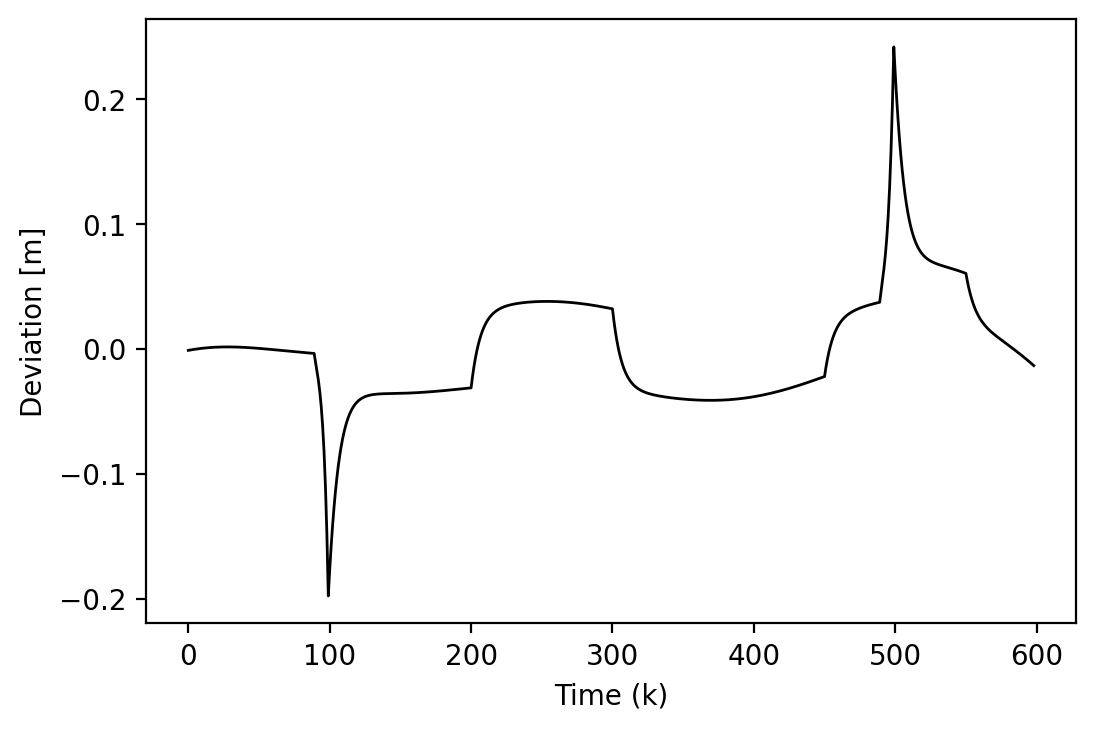

In [33]:
test_mean,test_cov = gpr.predict(Z)

plt.plot(Z[0:N-1, 2], test_mean[0:N-1,0], 'k', lw=1)

#plt.fill_between(Z[0:N-1,2], test_mean[0:N-1,0] - 1.96*np.sqrt(np.diag(test_cov[0:N-1,:])),
                 #test_mean[0:N-1,0] + 1.96*np.sqrt(np.diag(test_cov[0:N-1,:])),
                 #alpha=0.5, color="C0")
plt.ylabel('Deviation [m]')
plt.xlabel('Time (k)')
#print(test_mean)

#### Run the simualtion with GP-NMPC

In [34]:
z_LBNMPC = np.zeros((1, N+p))
u_LBNMPC = np.zeros(1)
u_LBNMPC[0] = 0
z_LBNMPC[0, 0] = z_init[0]

# derivatives
Hu = np.zeros((p,p))
Hz = np.zeros((p,p))

# inputs and states
z_bar = np.zeros((1, p)) 
Zd = np.zeros((1, p)) 
u = np.zeros((1, p))

# actual changes in input
delta_u = np.zeros((1, p))

In [35]:
import time

breaking = 0 # For testing to count how often optimization loop breaks
t1 = time.time() # For testing to track how long simulation takes
opt_time = 0 # For tracking the optimization loop frequency

for k in range(1, N):

    # Update the state from simulation
    z_LBNMPC[:, k] = process(u_LBNMPC, z_LBNMPC[:, k - 1], T, d[:, k - 1])

    # derive model d based on trained model
    x = [z_LBNMPC[:, k-1], u_LBNMPC, k-1]
    
    x = np.transpose(x).reshape(1,-1)

    x = np.array(x, dtype=np.float)
    
    t2 = time.time()
   
    pred_mean,pred_cov = gpr.predict(x)
    #d_mean,d_cov = gpr.predictive_gradients(x)
    d_mean,d_cov = gpr.predict_jacobian(x)
    #d1_mean,d_cov = gpr.predict_derivatives(x)

    print(d_mean)
    #print(d1_mean[0,0])
    #print(d1_mean)
   
    #+ mean_prime[0]
    t22 = time.time()

    # Populate Zd with the desired states over the prediction horizon
    Zd = zd[:, k + 1:k + 1 + p]
    # Populate u with the previous predicted inputs, shifted by 1
    for i in range(0, (p - 1)):
        u[:, i] = u[:, i + 1]
    u[:, p - 1] = 0
    
    t3 = time.time()

    # -------- Optimization --------#
    # occurs within a limited number of iterations
    for val in range(maxiterations):

        # Find the Hu and Hz as the instantaneous derivatives (constant in this case)         
        for b in range(0, p):
            if b < (p - 1):
                Hz[b + 1, b] = 1 - d_mean[0,0]
            Hu[b, b] = T - d_mean[0,1]

        z_bar[:, 0] = complete_process(u[:, 0], z_LBNMPC[:, k], T, pred_mean)  # fixed u[:,0]
        
        # z_bar is the state as a function of input u
        for j in range(1, p):
            z_bar[:, j] = complete_process(u[:, j], z_bar[:, j-1], T, pred_mean)
            
        H_prime = inv(np.eye(p) - Hz) @ Hu

        z_tild = np.transpose(Zd - z_bar)

        delta_u = inv(np.transpose(H_prime) @ Q @ H_prime + R) @ (
                    np.transpose(H_prime) @ Q @ z_tild - R @ np.transpose(u))

        # Update u
        u = u + np.transpose(delta_u)
        
        flag = 0  # counter to track if delta_u are below thresholds
        for i in range(0, p):
            if thresh > delta_u[i, :] > -thresh:
                flag += 1

        if flag == p:
            break
    
    opt_time += time.time() - t3 
    # Update our optimized input
    u_LBNMPC[:] = u[:, 0]
    
print('GP matrix time:', t2-t1, 's')
print('GP prediction time:', t22-t2, 's')
print('Average Optimization Frequency:', 1/(opt_time/(simtime/T)), 'Hz')    
print('Simulation Time:', time.time()-t1, 's')

[[[-0.00321782]
  [-0.00113928]
  [ 0.00021524]]]
[[[-0.00322794]
  [-0.00117158]
  [ 0.00020207]]]
[[[-0.00323782]
  [-0.00120563]
  [ 0.00019355]]]
[[[-0.00324761]
  [-0.00124001]
  [ 0.00018549]]]
[[[-0.00325735]
  [-0.00127453]
  [ 0.00017742]]]
[[[-0.00326704]
  [-0.00130919]
  [ 0.00016928]]]
[[[-0.00327667]
  [-0.001344  ]
  [ 0.00016111]]]
[[[-0.00328624]
  [-0.00137895]
  [ 0.00015293]]]
[[[-0.00329575]
  [-0.00141406]
  [ 0.00014475]]]
[[[-0.0033052 ]
  [-0.00144932]
  [ 0.0001366 ]]]
[[[-0.00331459]
  [-0.00148475]
  [ 0.0001285 ]]]
[[[-0.00332391]
  [-0.00152034]
  [ 0.00012045]]]
[[[-0.00333317]
  [-0.00155609]
  [ 0.00011247]]]
[[[-0.00334237]
  [-0.00159202]
  [ 0.00010457]]]
[[[-3.35149716e-03]
  [-1.62810668e-03]
  [ 9.67597444e-05]]]
[[[-3.36056008e-03]
  [-1.66436624e-03]
  [ 8.90476950e-05]]]
[[[-3.36955536e-03]
  [-1.70079382e-03]
  [ 8.14401055e-05]]]
[[[-3.37848226e-03]
  [-1.73738894e-03]
  [ 7.39430961e-05]]]
[[[-3.38734007e-03]
  [-1.77415080e-03]
  [ 6.656192

### Controller 4: Feedback Proportional Control

Generate states and populate the initial conditions.

In [36]:
z_FB = np.zeros((1, N+p))
u_FB = np.zeros(1)
u_FB[0] = 0
z_FB[0, 0] = z_init

Define the proportional gain.

In [37]:
K_FB = 25

Simulate closed loop system.

In [38]:
for k in range(0, N):
    
    # Compute the new input control signal
    u_FB[0] = K_FB*(zd[0, k] - z_FB[0, k])
    
    # Update the state by simulating the vehicle
    z_FB[0, k+1] = process(u_FB, z_FB[:, k], T, d[0, k])

### Controller 5: GP-FBL-MPC

## Plot

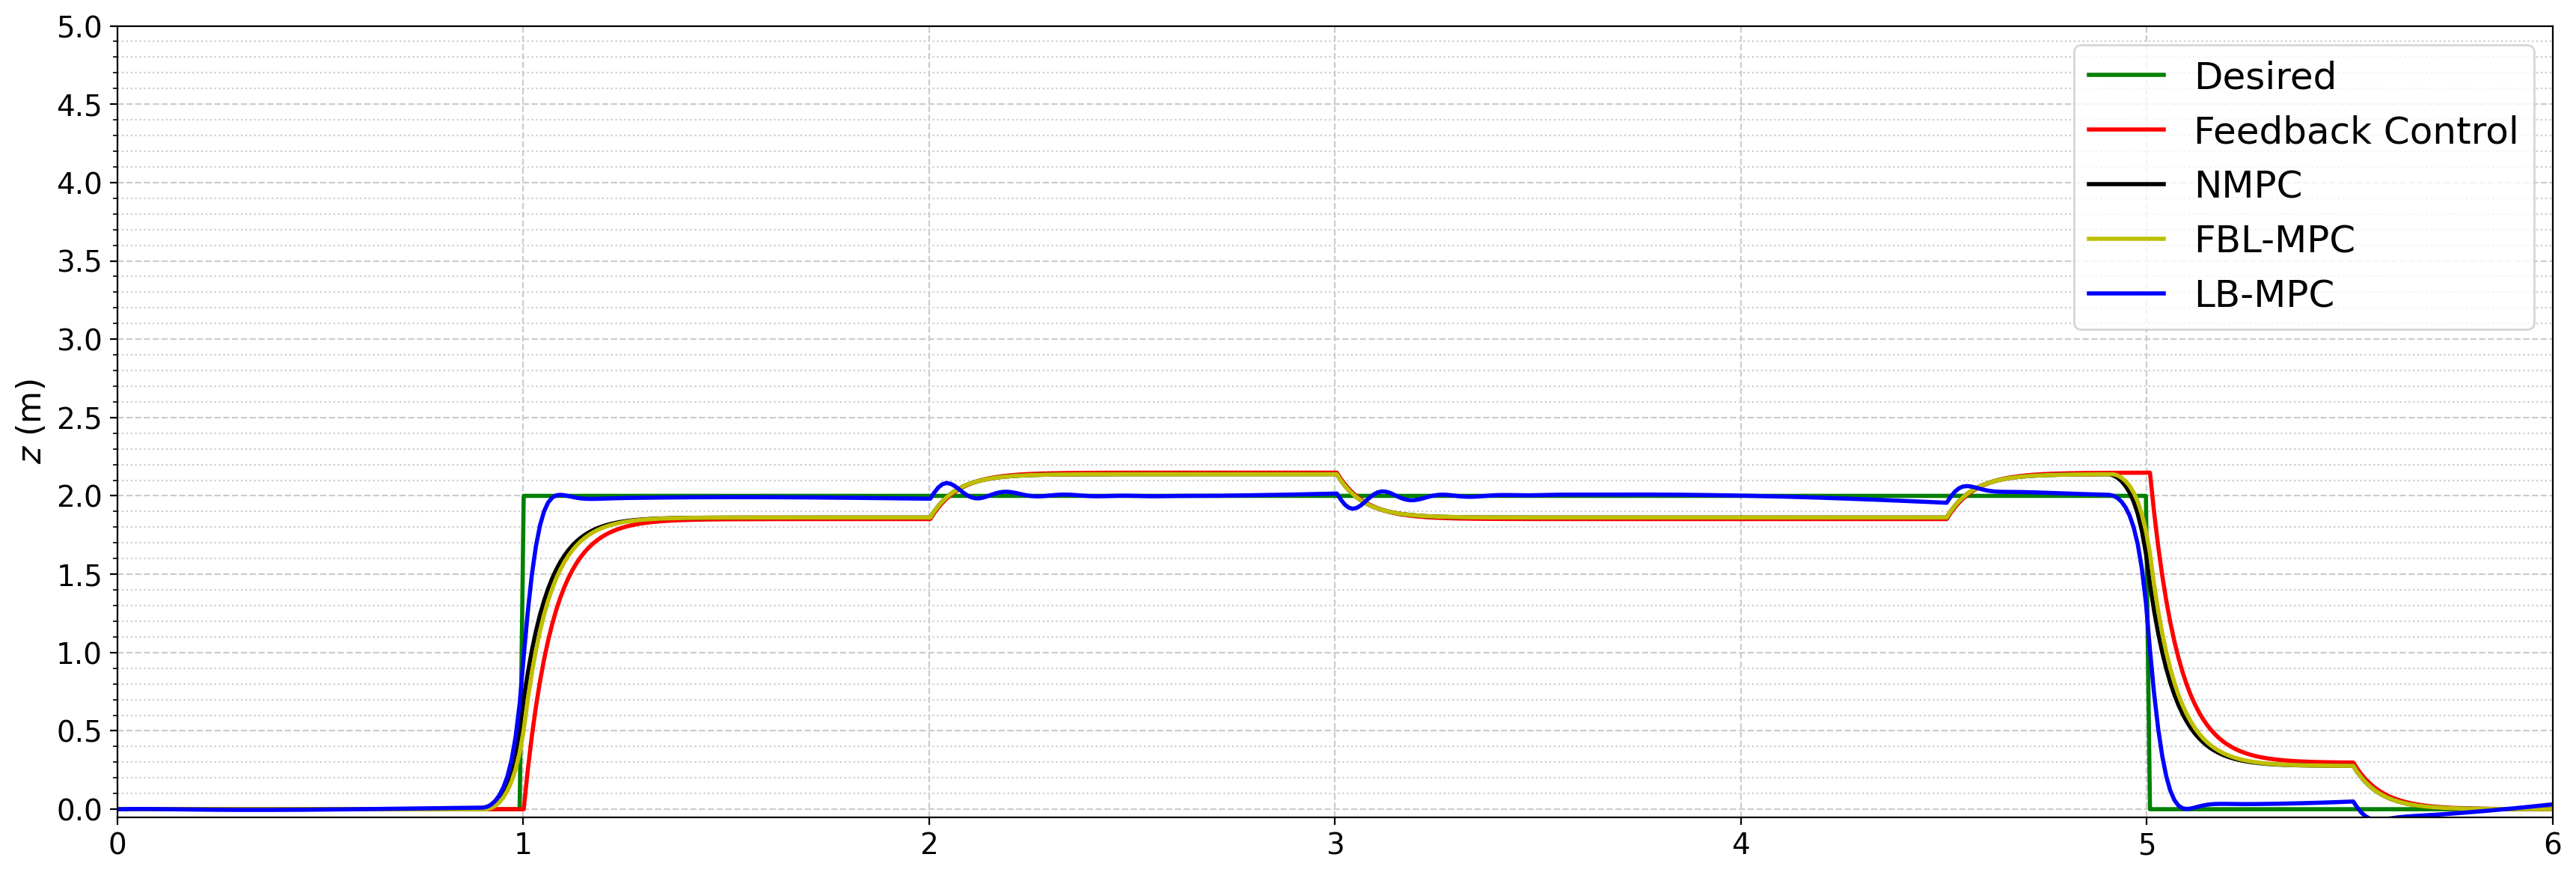

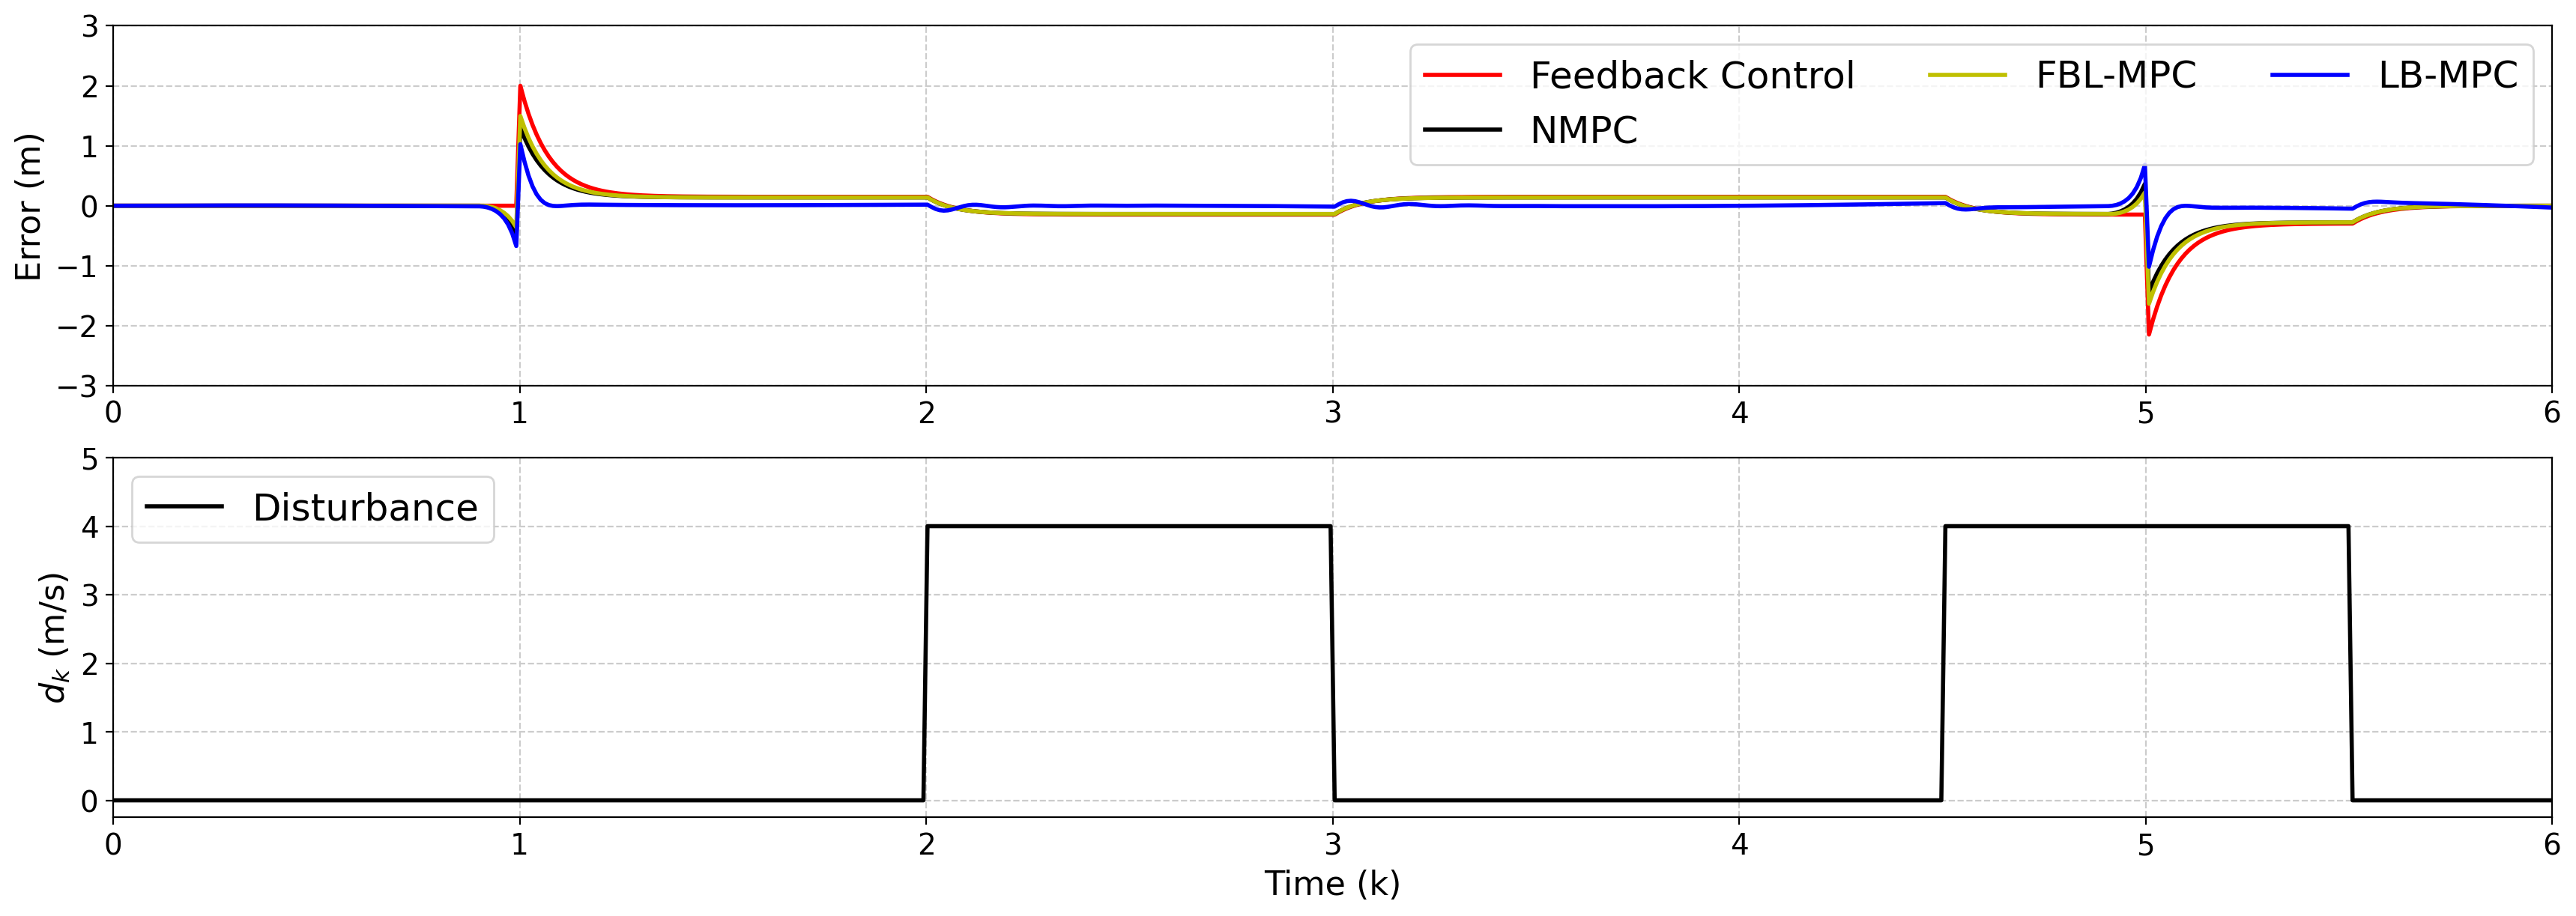

In [39]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig1, ((ax1)) = plt.subplots(1, 1, figsize=(21,7))

ax1.tick_params(labelsize=14)  # set axis number font size 
ax1.set_ylabel(r'$z$ (m)', fontsize = 16.0)  # set label font size 

ax1.plot(t, zd[0, 0:N], 'g', linewidth=2)
ax1.plot(t, z_FB[0, 0:N], 'r', linewidth=2)
ax1.plot(t, z_NMPC[0, 0:N], 'k', linewidth=2) # set line color 
ax1.plot(t, z_FBLMPC[0, 0:N], 'y', linewidth=2)
ax1.plot(t, z_LBNMPC[0, 0:N], 'b', linewidth=2)

# set plot grid: https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels-in-matplotlib
ax1.set_xlim(0, 6)
ax1.set_ylim(-0.05, 5)
# change major ticks to show every 1 & 0.5 
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
# change minor ticks to show every 1/5 = 0.1
#ax1.xaxis.set_minor_locator(AutoMinorLocator(1))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax1.grid(which='major', color='#CCCCCC', linestyle='--')
ax1.grid(which='minor', color='#CCCCCC', linestyle=':')

ax1.legend(['Desired', 'Feedback Control', 'NMPC', 'FBL-MPC', 'LB-MPC'], prop={'size': 18})   # set lengend font size

plt.savefig('3d_Deriv_states_gpy')
# ============= 
fig2, ((ax2, ax3)) = plt.subplots(2, 1, figsize=(21,7))

ax2.tick_params(labelsize=14)  # set axis number font size 
ax2.set_ylabel('Error (m)', fontsize = 16.0)  # set label font size 

ax2.plot(t, zd[0,  0:N]-z_FB[0, 0:N], 'r', linewidth=2)
ax2.plot(t, zd[0,  0:N]-z_NMPC[0, 0:N], 'k', linewidth=2)
ax2.plot(t, zd[0,  0:N]-z_FBLMPC[0, 0:N], 'y', linewidth=2)
ax2.plot(t, zd[0,  0:N]-z_LBNMPC[0, 0:N], 'b', linewidth=2)

# set plot grid
ax2.set_xlim(0, 6)
ax2.set_ylim(-3, 3)
# change major ticks to show every 1 & 0.5 
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.grid(which='major', color='#CCCCCC', linestyle='--')

ax2.legend(['Feedback Control', 'NMPC', 'FBL-MPC', 'LB-MPC'], prop={'size': 18}, loc="upper right", ncol = 3)   # lengend horizontal

# ============= 
ax3.tick_params(labelsize=14)  # set axis number font size 
ax3.set_ylabel(r'$d_k$ (m/s)', fontsize = 16.0)  # set label font size 

ax3.plot(t, d[0,  0:N], 'k', linewidth=2)

# set plot grid
ax3.set_xlim(0, 6)
ax3.set_ylim(-0.25, 5)
# change major ticks to show every 1 & 0.5 
ax3.xaxis.set_major_locator(MultipleLocator(1))
ax3.yaxis.set_major_locator(MultipleLocator(1))
ax3.grid(which='major', color='#CCCCCC', linestyle='--')

ax3.legend(['Disturbance'], prop={'size': 18})

plt.xlabel('Time (k)', fontsize=16)
plt.savefig('3d_Deriv_statesError_gpy')

#plt.show()

## Positive derivative signs 

In [40]:
z_LBNMPC = np.zeros((1, N+p))
u_LBNMPC = np.zeros(1)
u_LBNMPC[0] = 0
z_LBNMPC[0, 0] = z_init[0]

# derivatives
Hu = np.zeros((p,p))
Hz = np.zeros((p,p))

# inputs and states
z_bar = np.zeros((1, p)) 
Zd = np.zeros((1, p)) 
u = np.zeros((1, p))

# actual changes in input
delta_u = np.zeros((1, p))

In [41]:
import time

breaking = 0 # For testing to count how often optimization loop breaks
t1 = time.time() # For testing to track how long simulation takes
opt_time = 0 # For tracking the optimization loop frequency

for k in range(1, N):

    # Update the state from simulation
    z_LBNMPC[:, k] = process(u_LBNMPC, z_LBNMPC[:, k - 1], T, d[:, k - 1])

    # derive model d based on trained model
    x = [z_LBNMPC[:, k-1], u_LBNMPC, k-1]
    
    x = np.transpose(x).reshape(1,-1)
    #x = tf.convert_to_tensor(x, dtype=tf.float64)
   
    #print(x)
    # = np.transpose(x).reshape(1,-1)
    # = np.asarray(x)
    #x = np.transpose(x)
    # = np.asarray(x)
    x = np.array(x, dtype=np.float)
    
    t2 = time.time()
   
    pred_mean,pred_cov = gpr.predict(x)
    #d_mean,d_cov = gpr.predictive_gradients(x)
    d_mean,d_cov = gpr.predict_jacobian(x)
    #d1_mean,d_cov = gpr.predict_derivatives(x)

    #print(d_mean)
    #print(d1_mean[0,0])
    #print(d1_mean)
   
    #+ mean_prime[0]
    t22 = time.time()

    # Populate Zd with the desired states over the prediction horizon
    Zd = zd[:, k + 1:k + 1 + p]
    # Populate u with the previous predicted inputs, shifted by 1
    for i in range(0, (p - 1)):
        u[:, i] = u[:, i + 1]
    u[:, p - 1] = 0
    
    t3 = time.time()

    # -------- Optimization --------#
    # occurs within a limited number of iterations
    for val in range(maxiterations):

        # Find the Hu and Hz as the instantaneous derivatives (constant in this case)         
        for b in range(0, p):
            if b < (p - 1):
                Hz[b + 1, b] = 1 + d_mean[0,0]
            Hu[b, b] = T + d_mean[0,1]

        z_bar[:, 0] = complete_process(u[:, 0], z_LBNMPC[:, k], T, pred_mean)  # fixed u[:,0]
        
        # z_bar is the state as a function of input u
        for j in range(1, p):
            z_bar[:, j] = complete_process(u[:, j], z_bar[:, j-1], T, pred_mean)
            
        H_prime = inv(np.eye(p) - Hz) @ Hu

        z_tild = np.transpose(Zd - z_bar)

        delta_u = inv(np.transpose(H_prime) @ Q @ H_prime + R) @ (
                    np.transpose(H_prime) @ Q @ z_tild - R @ np.transpose(u))

        # Update u
        u = u + np.transpose(delta_u)
        
        flag = 0  # counter to track if delta_u are below thresholds
        for i in range(0, p):
            if thresh > delta_u[i, :] > -thresh:
                flag += 1

        if flag == p:
            break
    
    opt_time += time.time() - t3 
    # Update our optimized input
    u_LBNMPC[:] = u[:, 0]
    
print('GP matrix time:', t2-t1, 's')
print('GP prediction time:', t22-t2, 's')
print('Average Optimization Frequency:', 1/(opt_time/(simtime/T)), 'Hz')    
print('Simulation Time:', time.time()-t1, 's')

GP matrix time: 214.40388989448547 s
GP prediction time: 0.3332550525665283 s
Average Optimization Frequency: 91.86438552093853 Hz
Simulation Time: 214.75089263916016 s


In [42]:
z_FB = np.zeros((1, N+p))
u_FB = np.zeros(1)
u_FB[0] = 0
z_FB[0, 0] = z_init

K_FB = 25

for k in range(0, N):
    
    # Compute the new input control signal
    u_FB[0] = K_FB*(zd[0, k] - z_FB[0, k])
    
    # Update the state by simulating the vehicle
    z_FB[0, k+1] = process(u_FB, z_FB[:, k], T, d[0, k])

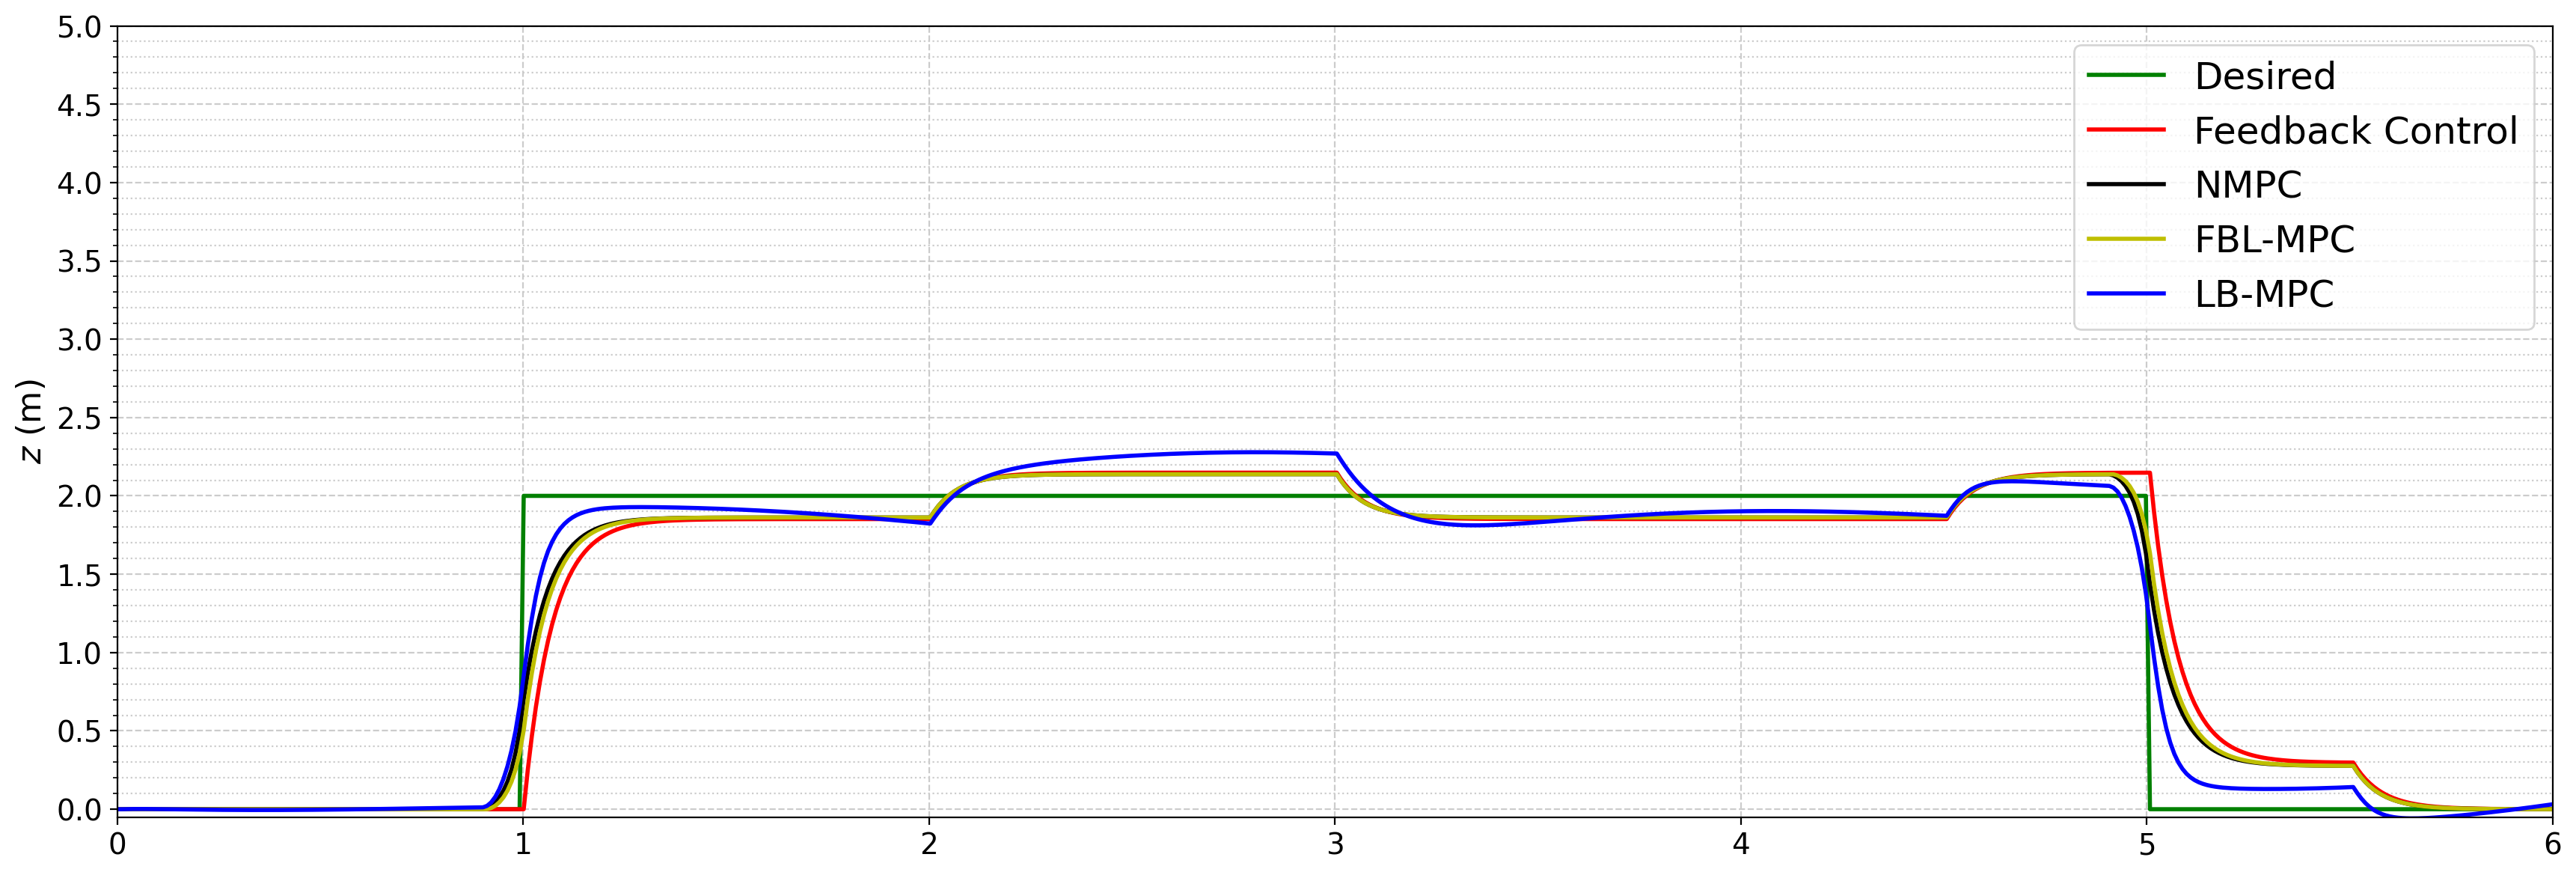

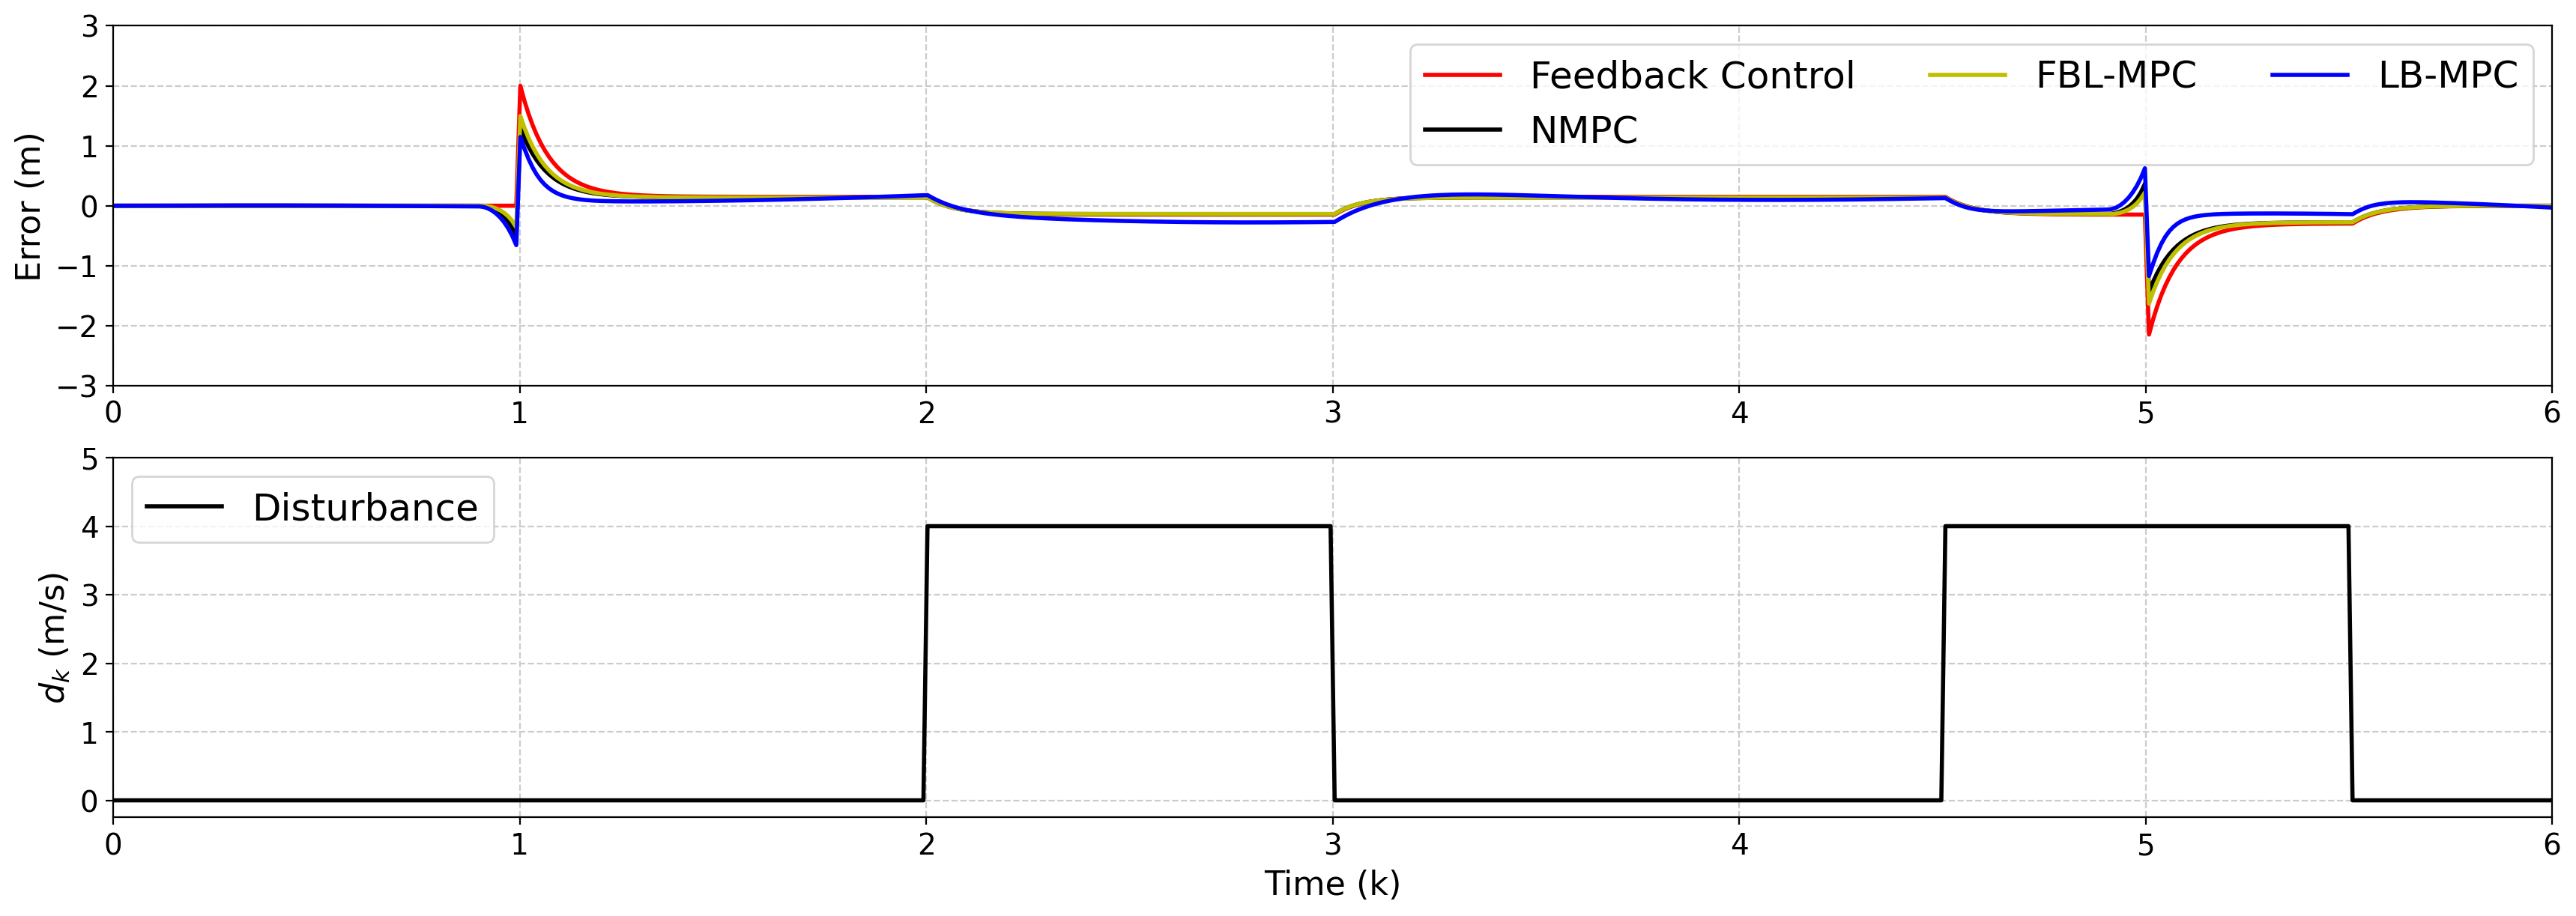

In [43]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig1, ((ax1)) = plt.subplots(1, 1, figsize=(21,7))

ax1.tick_params(labelsize=14)  # set axis number font size 
ax1.set_ylabel(r'$z$ (m)', fontsize = 16.0)  # set label font size 

ax1.plot(t, zd[0, 0:N], 'g', linewidth=2)
ax1.plot(t, z_FB[0, 0:N], 'r', linewidth=2)
ax1.plot(t, z_NMPC[0, 0:N], 'k', linewidth=2) # set line color 
ax1.plot(t, z_FBLMPC[0, 0:N], 'y', linewidth=2)
ax1.plot(t, z_LBNMPC[0, 0:N], 'b', linewidth=2)

# set plot grid: https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels-in-matplotlib
ax1.set_xlim(0, 6)
ax1.set_ylim(-0.05, 5)
# change major ticks to show every 1 & 0.5 
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
# change minor ticks to show every 1/5 = 0.1
#ax1.xaxis.set_minor_locator(AutoMinorLocator(1))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax1.grid(which='major', color='#CCCCCC', linestyle='--')
ax1.grid(which='minor', color='#CCCCCC', linestyle=':')

ax1.legend(['Desired', 'Feedback Control', 'NMPC', 'FBL-MPC', 'LB-MPC'], prop={'size': 18})   # set lengend font size

plt.savefig('3d_Deriv_states_gpy')
# ============= 
fig2, ((ax2, ax3)) = plt.subplots(2, 1, figsize=(21,7))

ax2.tick_params(labelsize=14)  # set axis number font size 
ax2.set_ylabel('Error (m)', fontsize = 16.0)  # set label font size 

ax2.plot(t, zd[0,  0:N]-z_FB[0, 0:N], 'r', linewidth=2)
ax2.plot(t, zd[0,  0:N]-z_NMPC[0, 0:N], 'k', linewidth=2)
ax2.plot(t, zd[0,  0:N]-z_FBLMPC[0, 0:N], 'y', linewidth=2)
ax2.plot(t, zd[0,  0:N]-z_LBNMPC[0, 0:N], 'b', linewidth=2)

# set plot grid
ax2.set_xlim(0, 6)
ax2.set_ylim(-3, 3)
# change major ticks to show every 1 & 0.5 
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.grid(which='major', color='#CCCCCC', linestyle='--')

ax2.legend(['Feedback Control', 'NMPC', 'FBL-MPC', 'LB-MPC'], prop={'size': 18}, loc="upper right", ncol = 3)   # lengend horizontal

# ============= 
ax3.tick_params(labelsize=14)  # set axis number font size 
ax3.set_ylabel(r'$d_k$ (m/s)', fontsize = 16.0)  # set label font size 

ax3.plot(t, d[0,  0:N], 'k', linewidth=2)

# set plot grid
ax3.set_xlim(0, 6)
ax3.set_ylim(-0.25, 5)
# change major ticks to show every 1 & 0.5 
ax3.xaxis.set_major_locator(MultipleLocator(1))
ax3.yaxis.set_major_locator(MultipleLocator(1))
ax3.grid(which='major', color='#CCCCCC', linestyle='--')

ax3.legend(['Disturbance'], prop={'size': 18})

plt.xlabel('Time (k)', fontsize=16)
plt.savefig('3d_Deriv_statesError_gpy')